In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db
import itertools as it
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as sla
import scipy.linalg as la
from collections import OrderedDict

import ccode.finite_system as tj
import ccode.tools as tl
import ccode.solvers as sl

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
a = 10e-9

In [4]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/trijunction_design/"  

# Triangular cavity

In [135]:
area = 800*a**2
angle = 0.6806784082777886
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "A": area,
    "angle": angle
}

In [136]:
center = np.sqrt(np.abs(area/np.tan(angle)))/2
geometry.update(centers=[center, -center])
triangle, f_params, _ = tj.finite_system(**geometry)
triangle = triangle.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [137]:
geometry = {
"A": area,
"l": 3*a,
"w": 1*a,
"a": a,
"w_v": 4*a,
"side": 'up',
"shape": 'v',
"angle": angle
}

In [138]:
border, f_params_border, _ = tj.finite_system(**geometry)
border = border.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


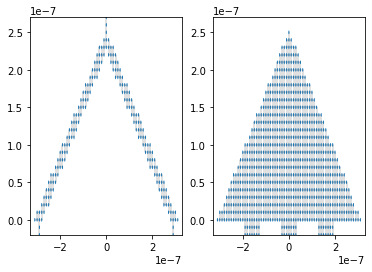

In [139]:
fig, ax = plt.subplots(ncols=2)
kwant.plot(border, ax=ax[0])
kwant.plot(triangle, ax=ax[1])
for axes in ax:
    axes.set_ylim(-0.2e-7, 2.7e-7)
    axes.set_xlim(-3.3e-7, 3.3e-7)

In [140]:
def f_noise_border(**params):
    # extract stdv noise
    sigma = params.pop('sigma')
    params.update(sigma=0)
    # add noise to border parameters
    zero_params = sl.junction_parameters([0, 0, 0], 0)
    zero_params.update(sigma=sigma)
    # create clean potential for triangle and noise potential for border
    f_mu_border = f_params_border(**zero_params)['mu']
    f = f_params(**params)
    f_mu = f['mu']

    def f_mu_noise(x, y):
        try:
            return f_mu_border(x, y) + f_mu(x, y)
        except:
            return f_mu(x, y)


    f.update(mu=f_mu_noise)
    return f

In [141]:
sigma = 1e-3
params = sl.junction_parameters(0, 0)
extra_params = sl.finite_coupling_parameters(index=0, sigma=sigma)
params.update(extra_params[-1])

In [142]:
f_params_noise_border = f_noise_border(**params)

In [143]:
def f_wrap(i):
    x, y = triangle.sites[i].pos
    return f_params_noise_border['mu'](x, y)

(-3.3e-07, 3.3e-07)

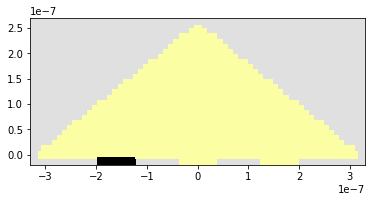

In [144]:
fig, ax = plt.subplots()
kwant.plotter.map(triangle, f_wrap, cmap='inferno', ax=ax)
ax.set_ylim(-0.2e-7, 2.7e-7)
ax.set_xlim(-3.3e-7, 3.3e-7)

In [46]:
# sanity check calculation without noise
mus_qd = np.linspace(-0.002, 0.002, 100)
index = 0

key = 'mu_qd'
n = 6
eigen = sl.solver(geometries=[[triangle, f_params]], n=n, key=key, eigenvecs=True)

In [47]:
def wrap(args):
    return eigen(*args)

In [48]:
params = sl.finite_coupling_parameters(index=0, sigma=0)
extra_params = sl.finite_coupling_parameters(index=0, sigma=0)
args = list(it.product([0], mus_qd, extra_params))
args_db = db.from_sequence(args, npartitions=20)

In [49]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/2dd24c7e9e3a43e0af81dccc70092461/status


In [50]:
couplings, wfs, _ = tl.coupling_data(result,eigenvecs=True)

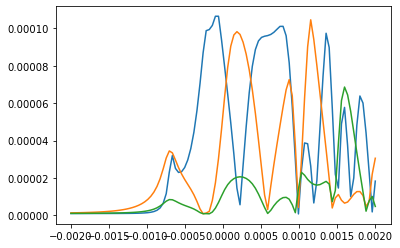

In [51]:
for coupling in couplings:
    plt.plot(mus_qd, coupling)

In [52]:
density = kwant.operator.Density(triangle, np.eye(4))

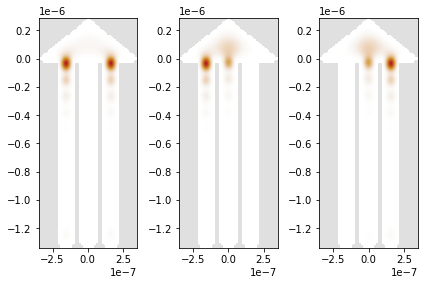

In [53]:
fig, ax = plt.subplots(ncols=3)
fig.tight_layout()
for i in range(3):
    kwant.plotter.density(triangle, density(wfs[i][30]), ax=ax[i])

# Noise along the borders

In [145]:
mus_qd = np.linspace(-0.0025, 0.002, 100)
index = 0

key = 'mu_qd'
n = 6
eigen = sl.solver(geometries=[[triangle, f_noise_border]], n=n, key=key, eigenvecs=False)

In [146]:
def wrap(args):
    return eigen(*args)

In [128]:
params = sl.finite_coupling_parameters(index=0, sigma=1e-4)
args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [147]:
data_sigmas = []

n_experiments = 4
sigmas = np.logspace(-4, -1, 10)
sigmas

array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ])

In [148]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for sigma in sigmas:
        data_sigma = []

        extra_params = sl.finite_coupling_parameters(index=index, sigma=sigma)
        args = list(it.product([0], mus_qd, extra_params))
        args_db = db.from_sequence(args, npartitions=20)

        for i in range(n_experiments):
            result = args_db.map(wrap).compute()
            couplings, _, _ = tl.coupling_data(result)
            data_sigma.append(couplings)

        data_sigmas.append(data_sigma)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/c489c2c5d5e4474787832cd9df571c6a/status


In [152]:
data_sigmas_all = np.array(data_sigmas)

In [153]:
averages = []
for i in range(len(sigmas)):
    mean = np.mean(data_sigmas_all[i].T, axis=2)
    averages.append(mean)
averages = np.array(averages)

In [154]:
pairs = ['left-right', 'left-center', 'center-right']

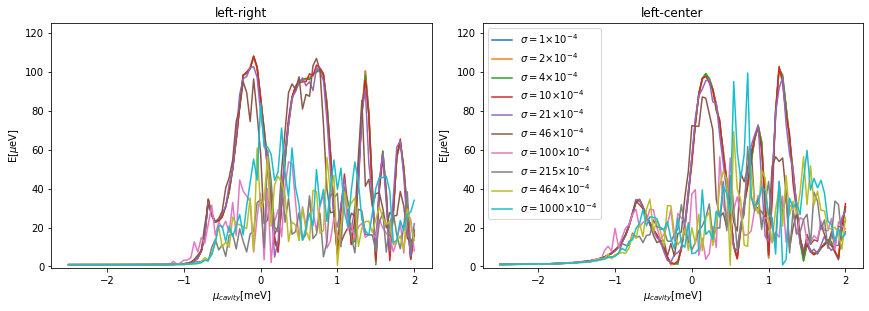

In [169]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.tight_layout(w_pad=2)
for i in range(2):
    j = 0
    for pair_lines in averages[:, :, i]:
        ax[i].plot(1e3*mus_qd, 1e6*pair_lines, label=r'$\sigma=$'+str(int(1e4*sigmas[j]))+r'$\times 10^{-4}$')
        j += 1
    ax[i].set_xlabel(r'$\mu_{cavity}$[meV]')
    ax[i].set_ylabel(r'E[$\mu$eV]')
    ax[i].set_ylim(-1, 125)
    ax[i].set_title(pairs[i])
ax[-1].legend()
#plt.title(r'MBS coupling: $\sigma=10^{-4}$')

# Noise everywhere

In [159]:
mus_qd = np.linspace(-0.0025, 0.002, 100)
index = 0

key = 'mu_qd'
n = 6
eigen = sl.solver(geometries=[[triangle, f_params]], n=n, key=key, eigenvecs=False)

In [160]:
def wrap(args):
    return eigen(*args)

In [161]:
params = sl.finite_coupling_parameters(index=0, sigma=1e-4)
args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [162]:
data_sigmas = []

n_experiments = 4
sigmas = np.logspace(-4, -1, 10)

In [163]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for sigma in sigmas:
        data_sigma = []

        extra_params = sl.finite_coupling_parameters(index=index, sigma=sigma)
        args = list(it.product([0], mus_qd, extra_params))
        args_db = db.from_sequence(args, npartitions=20)

        for i in range(n_experiments):
            result = args_db.map(wrap).compute()
            couplings, _, _ = tl.coupling_data(result)
            data_sigma.append(couplings)

        data_sigmas.append(data_sigma)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/5e741fbe8fe74546a8c77a83feb5c7ee/status


In [170]:
data_sigmas = np.array(data_sigmas)

In [171]:
averages = []
for i in range(len(sigmas)):
    mean = np.mean(data_sigmas[i].T, axis=2)
    averages.append(mean)
averages = np.array(averages)

In [172]:
pairs = ['left-right', 'left-center', 'center-right']

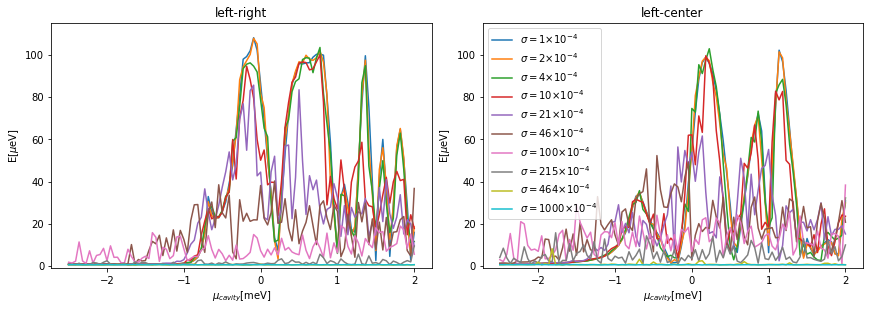

In [175]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.tight_layout(w_pad=2)
for i in range(2):
    j = 0
    for pair_lines in averages[:, :, i]:
        ax[i].plot(1e3*mus_qd, 1e6*pair_lines, label=r'$\sigma=$'+str(int(1e4*sigmas[j]))+r'$\times 10^{-4}$')
        j += 1
    ax[i].set_xlabel(r'$\mu_{cavity}$[meV]')
    ax[i].set_ylabel(r'E[$\mu$eV]')
    ax[i].set_ylim(-1, 115)
    ax[i].set_title(pairs[i])
ax[1].legend()
#plt.title(r'MBS coupling: $\sigma=10^{-4}$')

In [55]:
area = 200*a**2
angle = np.pi/4
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "A": area,
    "angle": angle,
    "radius": 10*a,
    "w_v": 11*a
}

In [56]:
border, f_params_border, _ = tj.finite_system(**geometry)
border = border.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


(-2.5e-07, 7.5e-07)

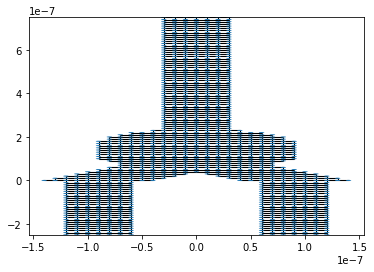

In [57]:
fig, ax = plt.subplots()
kwant.plot(border, ax=ax)
ax.set_ylim(-2.5e-7, 7.5e-7)